In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import math
# 忽略警告
import warnings
warnings.filterwarnings('ignore')

import pickle
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import numpy as np 
import joblib 
import os 

sns.set_style('whitegrid')
sns.set_palette('Set2')

TRANING = False

In [2]:
df = pd.read_csv('data/train.csv')

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">Nasdaq闭市拍卖介绍</span></h1>
</div>

 如果没有我们今天所讨论的closing auction，股票市场在收盘的时候可能会出现剧烈波动，这将带来严重的金融风险。为了应对这种风险，美国股市（我们讨论Nasdaq）引入了closing auction。
 
 closing auction的原理是在收盘前的最后10分钟，让买卖双方进行竞价，以确定收盘价。closing auction的成交量很大，将近10%的纳斯达克平均日交易量发生在收盘拍卖中。
 
 我们的研究在于通过预测未来60s的价格波动幅度来实现对于收盘价实现预测，以便于做市商能够更好的提高流动性（**主要是做市商**），同时避免单边行情的出现。同时为个人交易者提供更优的报价策略。（这个部分查询资料继续补充我们研究的重要性，从闭市拍卖的重要性，收盘价预测的复杂性，预测准了带来的好处&比如提高做市商的做市效率增大流动性）

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">0.1 拍卖机制介绍</span></h2>
</div>


## 1. closing auction的crossing auction机制（结合订单簿来叙述）
closing auction的auction机制是一个特殊的交易过程，旨在确定收盘价。最后的十分钟，除了连续订单簿以外还有收盘订单簿。最后的收盘价格是在合并订单簿上通过closing cross确定的。在这个过程中，所有挂单（包括MOC、LOC和IO订单）被汇集在一起，以确定一个交易价格。这个价格是在保证最大成交量的同时，尽量缩小买卖双方报价的差距。在交易的最后阶段，交易所的系统会自动匹配这些订单，找到一个最优的交易价格点，这个价格成为当日的官方收盘价。在这个过程中，交易所的订单簿会暂时冻结（无法撮合），以便进行这种集中式的价格计算和匹配。

closing auction的重要性在于：

1. 市场稳定性： closing auction有助于减少收盘时的价格波动，为市场提供稳定性。
2. 价格发现： 通过集中竞价，closing auction促进了更有效的价格发现机制，确保收盘价反映了市场的真实供需关系。
3. 风险管理： 对于投资者而言，closing auction提供了一种在明确价格下进行交易的方式，有助于更好地管理价格风险。
4. 流动性： 因为大量交易集中在收盘时进行，closing auction有助于增加市场流动性，特别是对于那些通常交易量较低的股票。

## 2. closing auction的订单类型
- MOC (Market on Close)：收盘市价订单（MOC）只是计划在收盘时以最新交易价格进行交易的市价订单。MOC 订单在接近收盘前保持休眠状态，此时它会变得活跃。一旦 MOC 订单生效，它的行为就像正常的市价订单一样。MOC订单可以帮助投资者以收盘价进场或离场，而无需在收盘时立即下市价单。**它需要在15:45前提交, 并且在15:50后不能取消或者修改。**
- LOC (Limit on Close)：限价收盘订单（LOC）是指以限定价格或更好价格执行的订单。如果收盘价优于或等于限定价格，订单将被执行。LOC订单为投资者提供了更多控制权，允许他们设定期望的最低或最高价格。
- IO (Imbalance Only)：仅不平衡订单（IO）是特定于收盘拍卖的订单类型。这些订单仅在存在不平衡（即买单和卖单之间的数量差异）时才会执行。IO订单有助于调节市场不平衡，促进在收盘时更有效的价格发现过程。

## 3. closing auction的时间线
- 15:50:00之前：可以提交MOC, LOC, IO订单，并且可以修改或者取消
- 15:50:00 - 15:55:00：可以提交MOC, LOC, IO订单，但是不能修改或者取消。开始提供 Net Order Imbalance Indicator（NOII）数据：Number of Paired Shares， Imbalance Side，Imbalance Quantity，Current Reference Price
- 15:55:00 - 15:58:00：停止接受MOC，继续接受LOC, IO订单，但是不能修改或者取消。继续提供NOII数据，并且开始提供Near Indicative Clearing Price，Far Indicative Clearing Price
- 15:58:00 - 16:00:00：停止接受MOC, LOC，继续接受IO订单，但是不能修改或者取消

![closing auction timeline](./pictures/timeline.png)

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">0.2 数据介绍</span></h2>
</div>

1. **`stock_id`（股票ID）** - 这是股票的唯一标识符。需要注意的是，并非所有股票ID在每个时间桶（时间段）都存在。

2. **`date_id`（日期ID）** - 日期的唯一标识符。日期ID是连续的，并且在所有股票中保持一致，以便于进行横向比较。

3. **`imbalance_size`（失衡大小）** - 指在当前参考价格下未能匹配的股票数量（以美元计）。这可以反映市场供需关系的紧张程度。

4. **`imbalance_buy_sell_flag`（买卖失衡标志）** - 这是一个指示拍卖失衡方向的标志，它包括：
    - 买方失衡（标记为1）
    - 卖方失衡（标记为-1）
    - 无失衡（标记为0）

5. **`reference_price`（参考价格）** - 合并订单簿的合意价格为最优bid ask中间的near price（如果near price超出 best bid或者best ask，则为near prcie），我们把它叫做`reference_price`。

6. **`matched_size`（匹配大小）** - 在当前参考价格下可以匹配的股票数量（以美元计）。

7. **`far_price`（远端价格）** - 收盘订单簿的最优交易价格。

8. **`near_price`（近端价格）** - 合并订单簿的最优交易价格。

9. **`[bid/ask]_price`（买入/卖出价格）** - 连续订单簿中最有竞争力的买入/卖出级别的价格。

10. **`[bid/ask]_size`（买入/卖出数量）** - 连续订单簿中最有竞争力的买入/卖出级别上的美元名义金额。

11. **`wap`（加权平均价格）** - 非拍卖账本中的加权平均价格，计算公式为 $$\frac{ {BidPrice \times AskSize + AskPrice \times BidSize}}{BidSize + AskSize} $$

12. **`seconds_in_bucket`（buccket秒数）** - 自当天收盘拍卖开始以来已经过的秒数，始终从0开始计算。

13. **`target`（目标值）** - 衡量股票的wap（加权平均价格）在未来60秒的变动幅度，减去合成指数在未来60秒的变动幅度。
    - 合成指数是Optiver为此竞赛构建的Nasdaq上市股票的自定义加权指数。
    - 目标值的单位是基点，这是金融市场中常用的计量单位。1基点的价格移动等同于0.01%的价格移动。
    - 目标值的计算公式为：$$ Target = (\frac{StockWAP_{t+60}}{StockWAP_{t}} - \frac{IndexWAP_{t+60}}{IndexWAP_{t}}) \times 10000 $$

**所有与大小相关的列的数值都以美元为单位。所有与价格相关的列的数值都转换为相对于拍卖期开始时股票wap（加权平均价格）的价格变动。**

> 参考
> 
> http://nasdaqtrader.com/Trader.aspx?id=OpenClose
> 
> https://www.nasdaqtrader.com/content/productsservices/Trading/ClosingCrossfaq.pdf
> 
> https://www.investopedia.com/terms/n/net-order-imbalance-indicator-noii.asp
> 
> https://www.investopedia.com/terms/i/imbalance-only-orders-io.asp

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">1.数据预处理</span></h1>
</div>

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">1.1 缺失值观察</span></h2>
</div>

In [3]:
df.isnull().sum()/df.shape[0]

stock_id                   0.000000
date_id                    0.000000
seconds_in_bucket          0.000000
imbalance_size             0.000042
imbalance_buy_sell_flag    0.000000
reference_price            0.000042
matched_size               0.000042
far_price                  0.552568
near_price                 0.545474
bid_price                  0.000042
bid_size                   0.000000
ask_price                  0.000042
ask_size                   0.000000
wap                        0.000042
target                     0.000017
time_id                    0.000000
row_id                     0.000000
dtype: float64

其中`row_id`: (data_id)\_(seconds_in_bucket)\_(stock_id)

并且观察缺失值比例，发现far_price 和 near_price 缺失值比例较大，但是这和拍卖机制有关，在后面加入分类变量来协助模型就好

其中matched_size，imbalance_buy_sell_flag，imbalance_size，reference_price 是闭市拍卖中在3:50到3:55的会给出的，3:55同时结束MOC，之后会给出near_price和far_price，然后在3:58停止LOC，IO在4:00结束。具体见下图所示，本问题的好处在于前四个指标都给出了，同时还给了其他的指标用于提高模型的准确性。这同时意味着需要我们对于特征工程的处理要更加细致。

<Axes: title={'center': 'Stock 7'}, xlabel='seconds_in_bucket'>

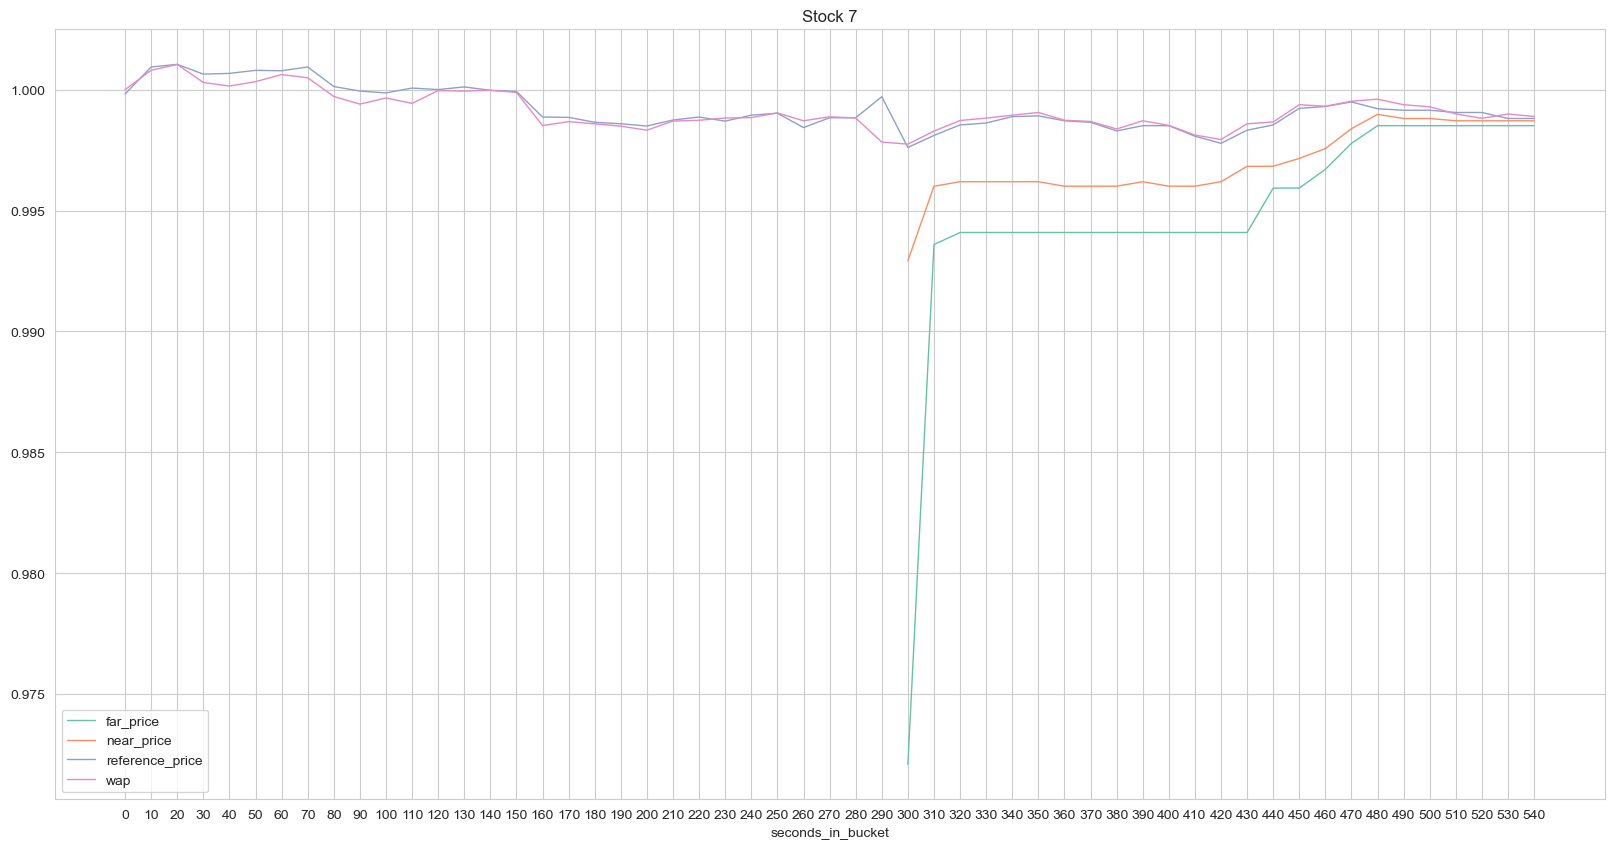

In [4]:
stock_id = 7

df.query(f'stock_id == {stock_id} & date_id ==0')[['seconds_in_bucket','far_price','near_price','reference_price','wap']].set_index(
    'seconds_in_bucket').plot(
        title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, 550, 10))

<Axes: title={'center': 'Stock 7'}, xlabel='time_id'>

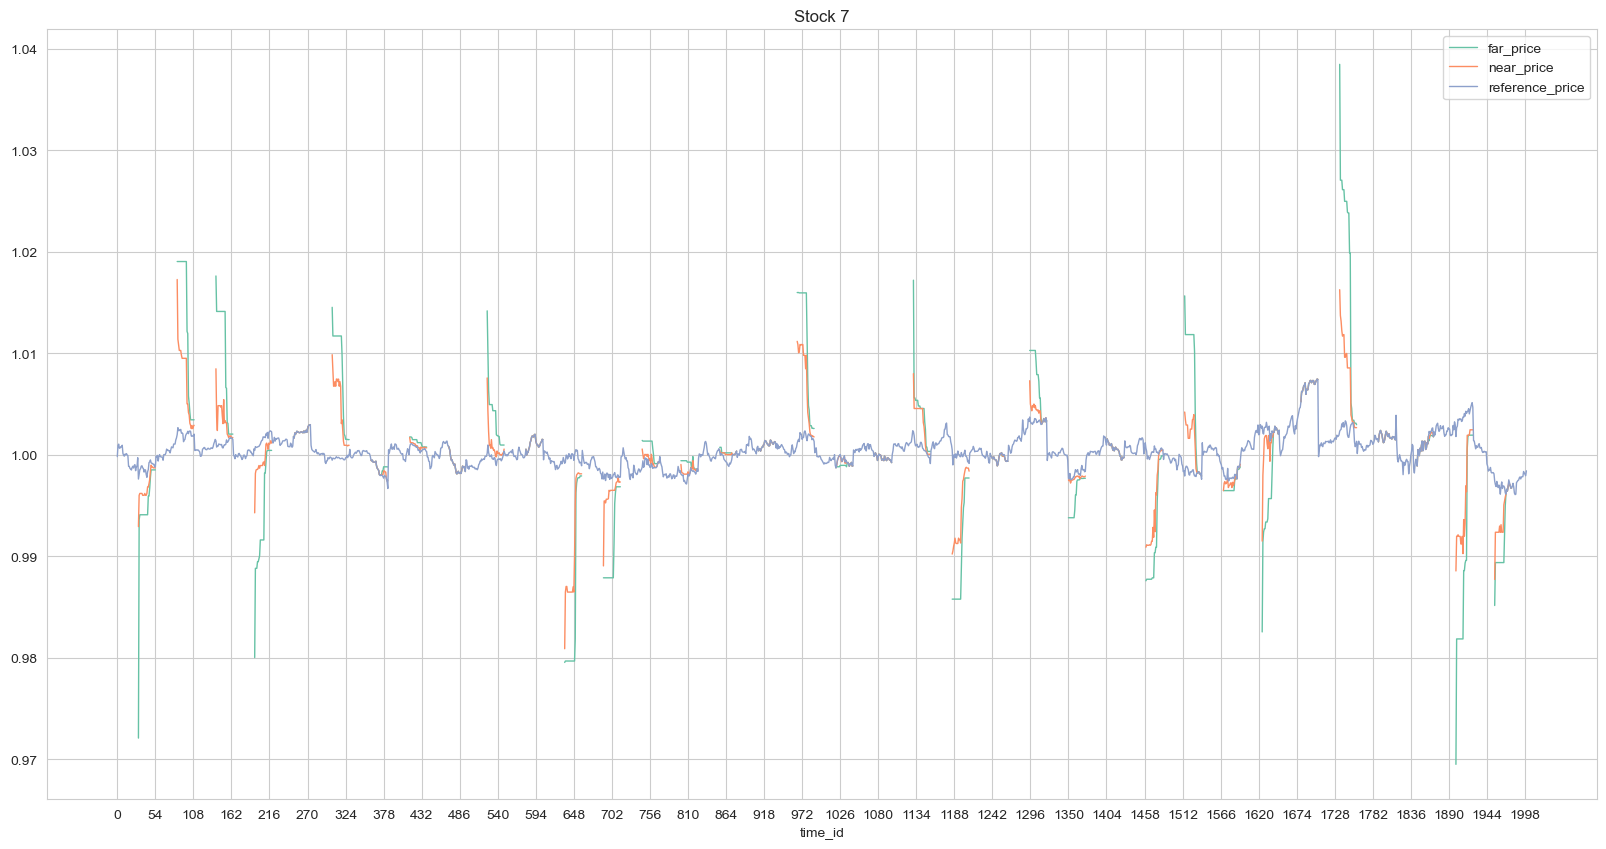

In [5]:
stock_id = 7
time_long = 2000
df.query(f'stock_id == {stock_id} & time_id <={time_long}')[['time_id','far_price','near_price','reference_price']].set_index(
    'time_id').plot(
        title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, time_long+1, 54))

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">1.2 缺失值处理</span></h2>
</div>

- 对于target缺失的，暂时删去stock
- 对于其他数据缺失的，对于相同stock_id，相同date_id的，数据类似于[nan,nan,nan,10,9,8],则用[10,10,10,10,9,8]填充，如果是[nan,nan,nan,nan,nan,nan]，则用[0,0,0,0,0,0]填充

## 处理target缺失值

In [6]:
if TRANING:
    np.sort(df[(df['target'].isnull())]['stock_id'].unique()).tolist()

In [7]:
if TRANING:
    df.isnull().sum()/df.shape[0]

In [8]:
if TRANING:
    # 对于target为nan的数据，丢弃
    df = df[~df['stock_id'].isin(np.sort(df[(df['target'].isnull())]['stock_id'].unique()).tolist())] 


In [9]:
if TRANING:
    df.isnull().sum()/df.shape[0]

说明target为nan的确实是有问题的数据

## 处理其他缺失值

In [10]:
if TRANING:
    df['far_price'] = df.groupby(['stock_id', 'date_id'])['far_price'].apply(lambda x: x.bfill().fillna(0)).reset_index(level=[0,1], drop=True)
    df['near_price'] = df.groupby(['stock_id', 'date_id'])['near_price'].apply(lambda x: x.bfill().fillna(0)).reset_index(level=[0,1], drop=True)

In [11]:
if TRANING:
    df.isnull().sum()/df.shape[0]

## 现在没有缺失值了，画图效果如下

In [12]:
if ~TRANING:
    df = pd.read_csv('data/train_cleaned.csv')

<Axes: title={'center': 'Stock 7'}, xlabel='time_id'>

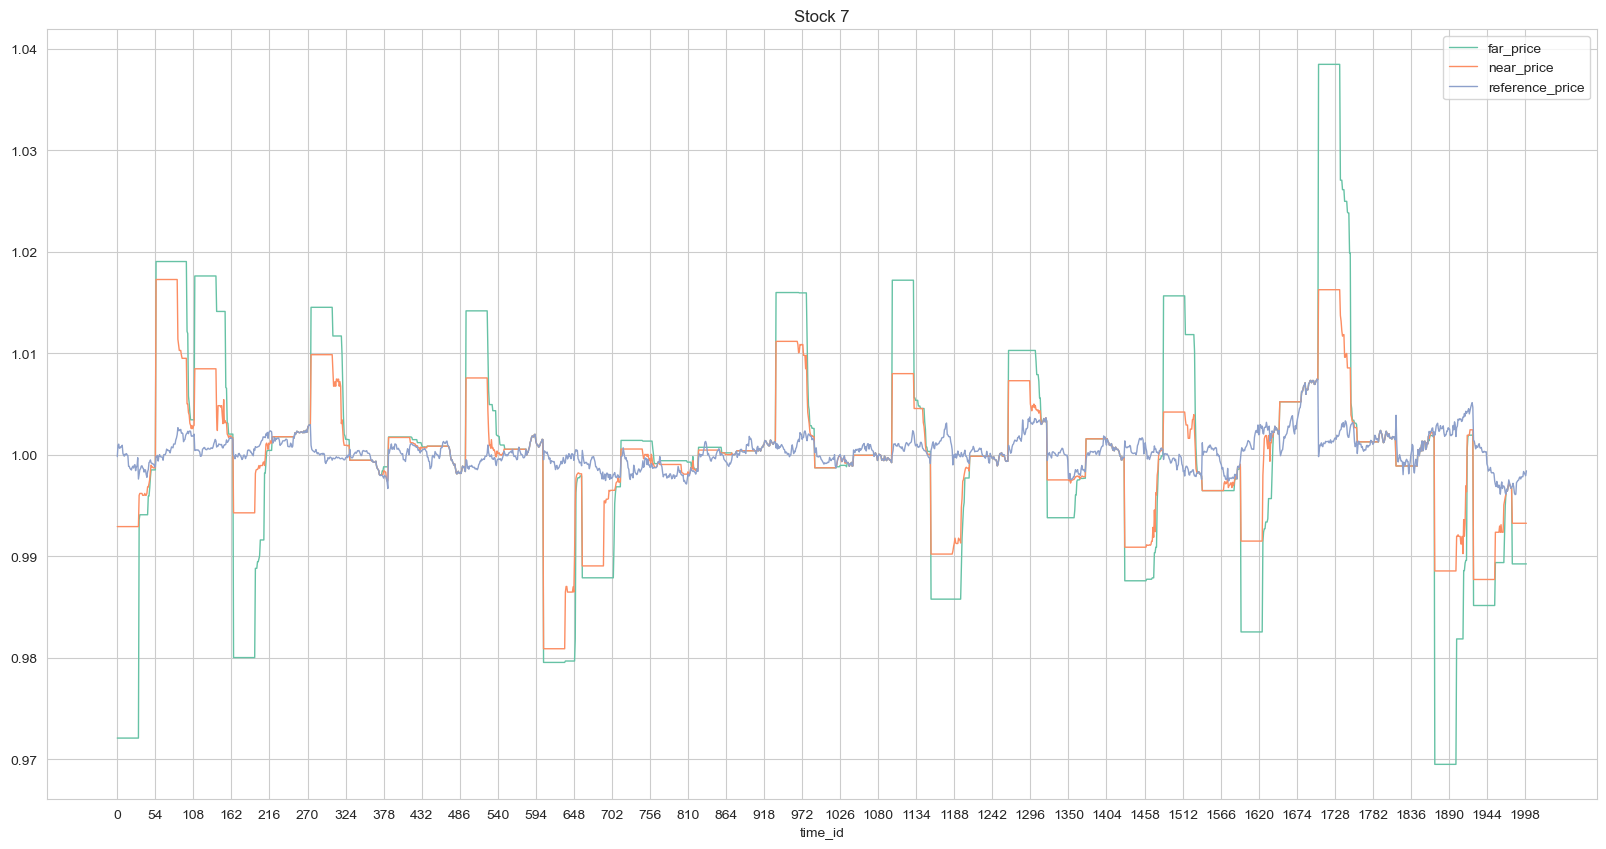

In [13]:
stock_id = 7
time_long = 2000
df.query(f'stock_id == {stock_id} & time_id <={time_long}')[['time_id','far_price','near_price','reference_price']].set_index(
    'time_id').plot(
        title=f'Stock {stock_id}', figsize=(20, 10), lw=1, xticks=np.arange(0, time_long+1, 54))

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">2. 特征工程</span></h1>
</div>

## 生成特征

In [14]:
def generate_features(df):
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag', 'imbalance_size', 
                        'matched_size', 'bid_size', 'ask_size', 'reference_price', 
                        'far_price', 'near_price', 'ask_price', 'bid_price', 'wap', 
                        'target','after55','imb','imb_s1','imb_s2']
    

    df['imb'] = df['imbalance_buy_sell_flag'] * df['imbalance_size']
    df['imb_s1'] = (df['bid_size'] - df['ask_size']) / (df['bid_size'] + df['ask_size'])
    df['imb_s2'] = (df['imbalance_size'] - df['matched_size']) / (df['matched_size'] + df['imbalance_size'])
    df['after55'] = df['seconds_in_bucket'].apply(lambda x: 1 if x > 290 else 0)

    prices = ['reference_price', 'far_price', 'near_price', 'ask_price', 'bid_price', 'wap']


    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            if i > j:
                df[f'{a}_{b}_imb'] = (df[a] - df[b]) / (df[a] + df[b])
                df[f'{a}_{b}_imb2'] = (df[a] * df[b]) / (df[a] + df[b])
                features.extend([f'{a}_{b}_imb', f'{a}_{b}_imb2'])


    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = df[[a, b, c]].max(axis=1)
                    min_ = df[[a, b, c]].min(axis=1)
                    mid_ = df[[a, b, c]].sum(axis=1) - min_ - max_
                    df[f'{a}_{b}_{c}_imb'] = (max_ - mid_) / (mid_ - min_)
                    df[f'{a}_{b}_{c}_imb2'] = (max_ - min_) / (mid_ + min_)
                    features.extend([f'{a}_{b}_{c}_imb', f'{a}_{b}_{c}_imb2'])

    print("size", df.shape)

    return df[features]



TRAIN = True
if TRAIN:
    df_gen = generate_features(df)

size (5132160, 92)


In [15]:
def drop_columns_with_infinite(df, threshold=500):
    infinite_count = df.isin([np.inf, -np.inf]).sum()
    columns_to_drop = infinite_count[infinite_count > threshold].index
    return df.drop(columns=columns_to_drop)

df_gened = drop_columns_with_infinite(df_gen)

In [16]:
target = df_gened['target']
features = df_gened.drop(columns=['target'])

In [17]:
if TRANING:
    # 按照数据顺序划分训练集和验证集
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.2, shuffle=False)

    model = xgb.XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.01, subsample=0.8, colsample_bytree=0.8, random_state=2023, early_stopping_rounds=50,objective='reg:squarederror')
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)

    from sklearn.metrics import mean_absolute_error
    mean_absolute_error(y_valid, model.predict(X_valid))
    pickle.dump(model, open('models/model_fe.pkl', 'wb'))
else:
    model = pickle.load(open('models/model_fe.pkl', 'rb'))


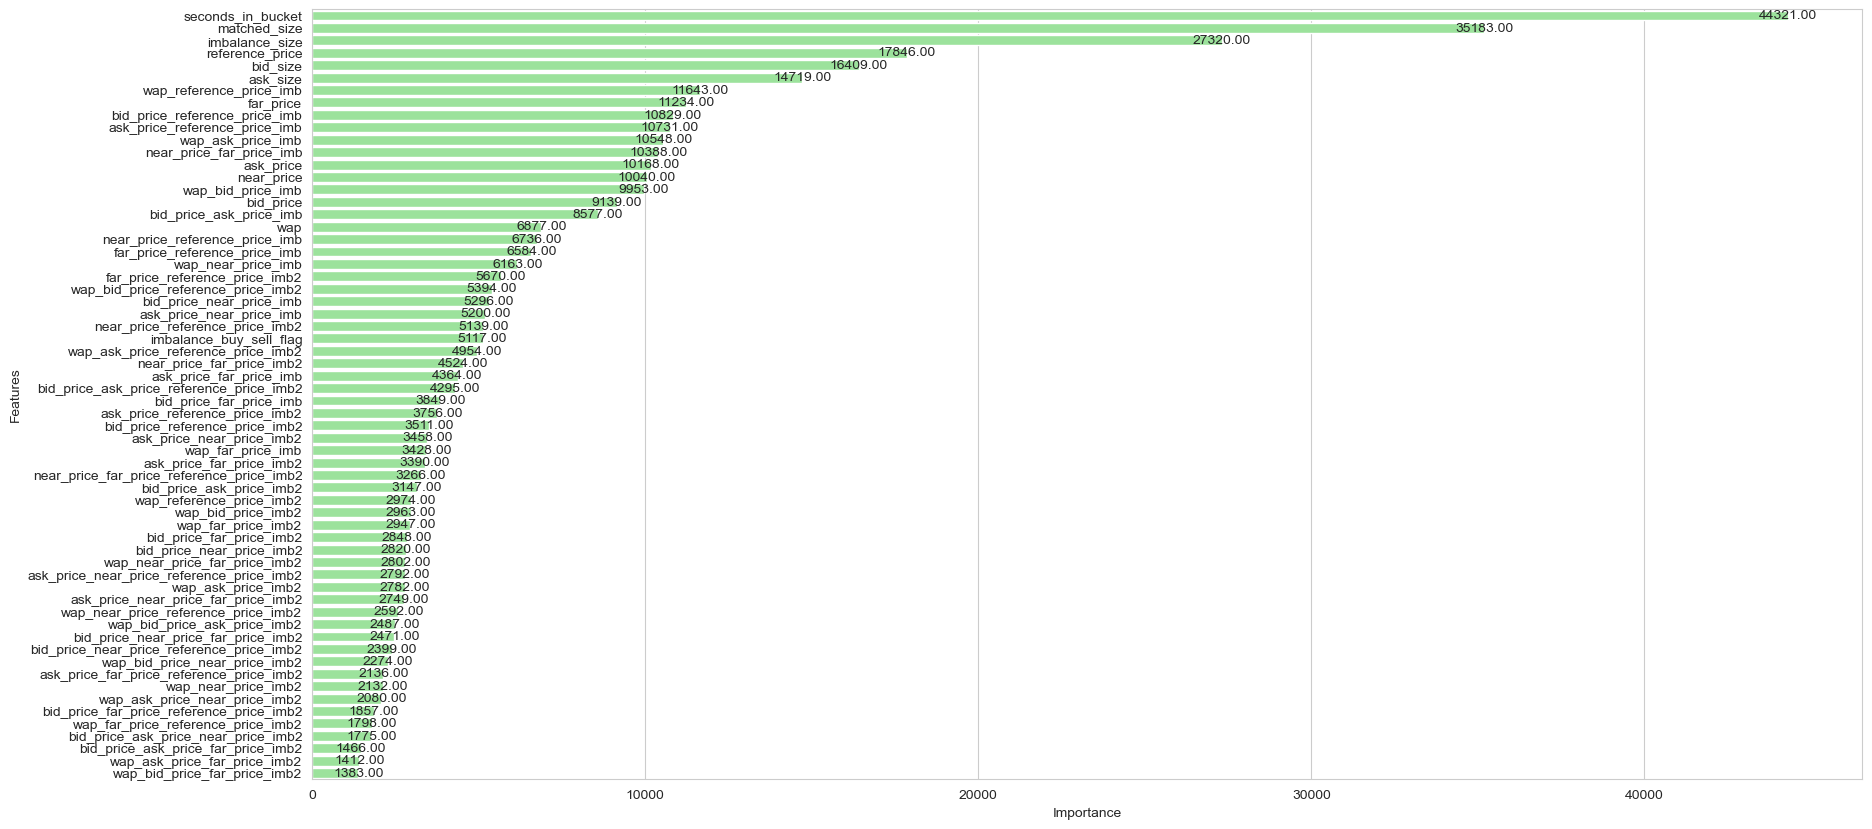

In [18]:
# 绘图
importance = model.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame({'Features': list(importance.keys()), 'Importance': list(importance.values())})

plt.figure(figsize=(20, 10))
barplot = sns.barplot(x='Importance', y='Features', data=importance_df.sort_values(by='Importance', ascending=False), color='lightgreen')

for p in barplot.patches:
    width = p.get_width()    
    plt.text(width + 0.3,    
             p.get_y() + p.get_height() / 2, 
             '{:1.2f}'.format(width), 
             ha = 'center',   
             va = 'center')   

plt.show()

In [19]:
# 选取重要性大于8000的特征，同时查看特征包含'after55','imb','imb_s1','imb_s2'与否，没有需要从df加入
important_features = importance_df[importance_df['Importance'] > 8000]['Features'].tolist()
df_ultimate = df_gen[important_features]
for i in ['after55','imb','imb_s1','imb_s2','target']:
    if i not in important_features:
        #df_ultimate由df和df_gen合并而来
        df_ultimate[i] = df[i]
df_ultimate.columns      

Index(['seconds_in_bucket', 'imbalance_size', 'matched_size', 'bid_size',
       'ask_size', 'reference_price', 'far_price', 'near_price', 'ask_price',
       'bid_price', 'near_price_far_price_imb',
       'ask_price_reference_price_imb', 'bid_price_reference_price_imb',
       'bid_price_ask_price_imb', 'wap_reference_price_imb',
       'wap_ask_price_imb', 'wap_bid_price_imb', 'after55', 'imb', 'imb_s1',
       'imb_s2', 'target'],
      dtype='object')

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">3. 聚类分析</span></h1>
</div>

我们需要分别对特征和stock做聚类，对相同类的stock，我们可以用一个模型来预测，这样可以提高模型的准确性，同时也可以减少模型的训练时间。
另外，我们可以对特征做聚类，类似于特征工程

In [20]:
# dtw distance
def DTWDistance(s1, s2):
    DTW={}
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0
    for i in range(len(s1)):
        for j in range(len(s2)):
            dist = (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return math.sqrt(DTW[len(s1)-1, len(s2)-1])

In [23]:
# 在dtw距离基础上构建层次聚类 TODO: 优化距离传入
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

def hierarchical_clustering(df, threshold=0.1):
    Z = linkage(df, method='ward', metric=DTWDistance)
    # plot
    plt.figure(figsize=(20, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(Z, leaf_rotation=90., leaf_font_size=8.,)
    plt.axhline(y=threshold, c='k')
    plt.show()

hierarchical_clustering(df_ultimate) 
    

MemoryError: Unable to allocate 95.8 TiB for an array with shape (13169530566720,) and data type float64

<div style="background-color:#e3f2fd; padding: 20px; border: 2px solid #1E88E5; border-radius: 10px;">
    <h1 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:150%; text-align:center">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 10px; border-radius: 5px;">4. 模型训练和调优</span></h1>
</div>

<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">4.1 简单试试baseline</span></h2>
</div>

In [ ]:
X = df_ultimate.drop(columns=['target'])
y = df_ultimate['target']
# 定义模型参数
params = {
    'n_estimators': 1000,
    'max_depth': 10,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'reg:squarederror',  
    'random_state': 2023,
    'verbosity': 2
}

# 初始化模型
model_xgb = xgb.XGBRegressor(**params)

# 计算交叉验证分数
score = -1 * cross_val_score(model_xgb, X, y, cv=3, scoring='neg_mean_absolute_error').mean()
print("xgb的分数是", score)

xgb的分数是 6.00771424598519


<div style="background-color:#e3f2fd; padding: 10px; border: 2px solid #1E88E5; border-radius: 5px;">
    <h2 style="font-family:Courier New, monospace; font-weight:bold; letter-spacing: 2px; color:#1565C0; font-size:120%; text-align:left">
    <span style="background-color:#1E88E5; color:#ffffff; padding: 5px; border-radius: 5px;">4.2 模型超参数搜索</span></h2>
</div>

In [ ]:
N_fold = 5

X = df_ultimate.drop(columns=['target']).values
Y = df_ultimate['target'].values
index = np.arange(X.shape[0])

models = []

def objective(trial):
    model_name = trial.suggest_categorical('model', ['lgb', 'xgb', 'cbt'])
    if model_name == 'lgb':
        param = {
            'objective': 'regression_l1',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
            'num_leaves': trial.suggest_int('num_leaves', 2, 256),
            'max_depth': trial.suggest_int('max_depth', 1, 32),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),    
        }
        model = lgb.LGBMRegressor(**param)
    elif model_name == 'xgb':
        param = {
            'tree_method': 'hist',
            'objective': 'reg:regression_l1',
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 32),
            'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        }
        model = xgb.XGBRegressor(**param)
    elif model_name == 'cbt':
        param = {
            'objective': 'MAE',
            'iterations': trial.suggest_int('iterations', 100, 5000),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1.0),
            'depth': trial.suggest_int('depth', 1, 10),
            'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
            'random_strength': trial.suggest_uniform('random_strength', 0.0, 1.0),
        }
        model = cbt.CatBoostRegressor(**param)

    # 交叉验证
    scores = []
    for i in range(N_fold):
        model.fit(X[index % N_fold != i], Y[index % N_fold != i], 
                  eval_set=[(X[index % N_fold == i], Y[index % N_fold == i])], 
                  verbose=10, 
                  early_stopping_rounds=100)
        score = model.score(X[index % N_fold == i], Y[index % N_fold == i])
        scores.append(score)
    return np.mean(scores)

## 超参数搜索

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  

best_params = study.best_params
best_model_name = best_params['model']
del best_params['model']

In [ ]:
# 使用最佳参数训练模型
if best_model_name == 'lgb':
    model = lgb.LGBMRegressor(**best_params)
elif best_model_name == 'xgb':
    model = xgb.XGBRegressor(**best_params)
elif best_model_name == 'cbt':
    model = cbt.CatBoostRegressor(**best_params)

for i in range(N_fold):
    model.fit(X[index % N_fold != i], Y[index % N_fold != i], 
              eval_set=[(X[index % N_fold == i], Y[index % N_fold == i])], 
              verbose=10, 
              early_stopping_rounds=100)
    joblib.dump(model, f'models/{best_model_name}_{i}.model')
    models.append(model)